## Monitoring Global Snow Cover Using MODIS Imagery
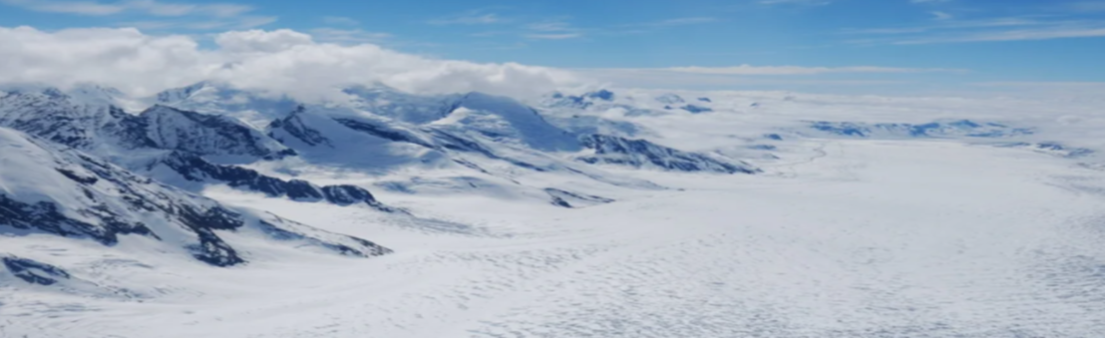
## **Source imagery**: 
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MODIS Snow Cover Monthly Products from 2000- 2020             https://modis.gsfc.nasa.gov/data/dataprod/mod10.php
## **Workflow**
####   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0. Open an imagery layer as an image cube.
####   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1. Calculate snow cover frequency of 21 years. 
####   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2. Calculate seasonal snow cover frequency of 21 years. 
####   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. Analyze  snow cover trend.
####   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4. Predict future snow cover frequency.

In [1]:
import arcgis
from arcgis.gis import GIS
gis = GIS("https://esri-rasterdev.maps.arcgis.com/home", "", "") #specify your portal, username and password

### Create a multidimensional raster from the imagery layer

In [2]:
#create a multidimensional raster
from arcgis.raster import Raster
snow_cover = gis.content.search("GlobalSnowCover_2000_2020")[0]
snow_cover_monthly = Raster(snow_cover.layers[0].url, True, gis=gis)
snow_cover_monthly.variables

['snow_cover_monthly_cmg(StdTime=245)']

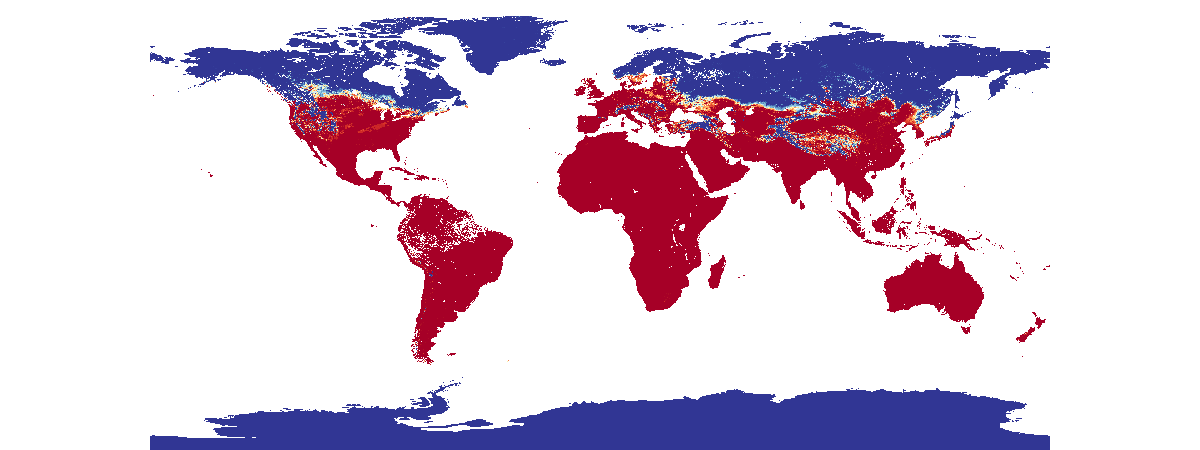

In [13]:
#display the multidimensional raster
from arcgis.raster.functions import stretch, colormap 
snow_cover_monthly_stretch = stretch(snow_cover_monthly ,stretch_type = "StdDev", statistics = [0,100,46.2,48.7])
snow_cover_monthly_colormap = colormap(snow_cover_monthly_stretch, colormap_name="Red-Yellow-Blue (Continuous)") #"Spectrum-Full Bright"
snow_cover_monthly_colormap

### Calculate snow cover frequence (2000-2020)

#### Total snow cover frequency
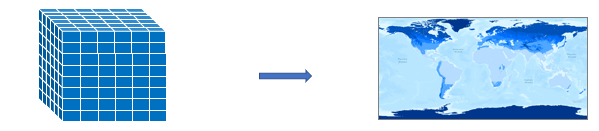

In [ ]:
from arcgis.raster.analytics import aggregate_multidimensional_raster
mean_frequency = aggregate_multidimensional_raster(snow_cover_monthly, dimension='StdTime', variables=["snow_cover_monthly_cmg"],
                                                     aggregation_method='MEAN',
                                                     aggregation_definition='ALL',
                                                     output_name='snowcover_mean_frequency2',
                                                     gis=gis,
                                                     folder="demoSnowCover")
mean_frequency_raster = Raster(mean_frequency.layers[0].url, True, gis=gis)

In [5]:
from arcgis.raster.functions import remap, colormap
mean_frequency_remap = remap(mean_frequency_raster, input_ranges=[-100,0.0001, 0.0001, 10, 10, 25, 25, 40, 40, 50, 50, 70, 70,95, 95, 101], output_values=[1,2,3,4,5,6,7,8])
mean_frequency_colormap = colormap(mean_frequency_remap, colormap=[[1,190,232,255], [2,79,167,255], [3,25,132,255], [4,0,108,249], [5,0,96,218], [6,0,82,184], [7,0,68,159], [8,0,55,141]])
mean_frequency_colormap

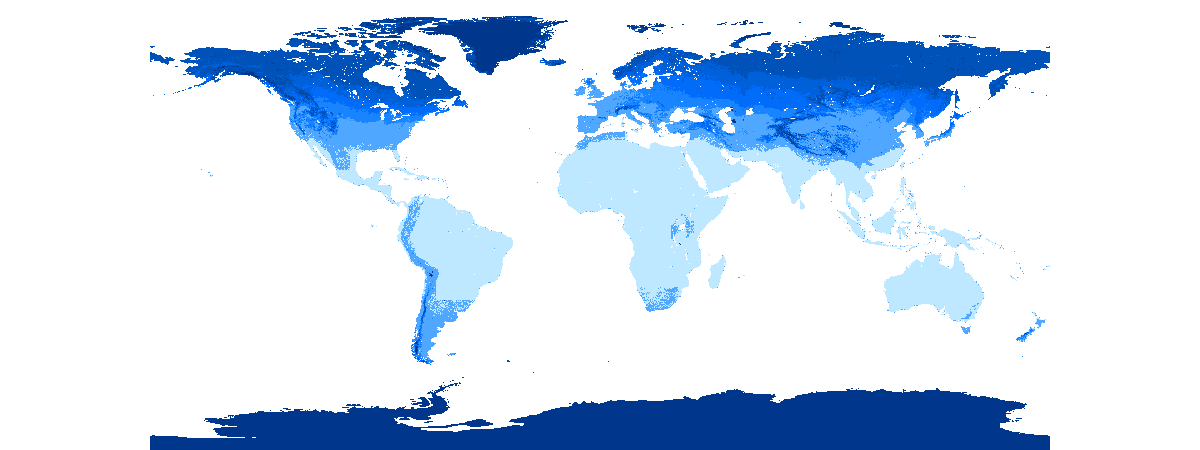

In [6]:
mean_frequency_colormap

#### Caculate seasonal snow cover frequency 
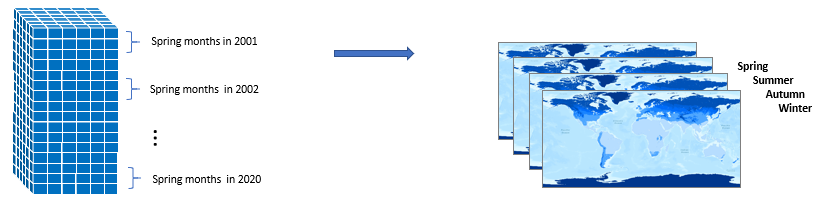

In [18]:
from arcgis.raster.analytics import aggregate_multidimensional_raster
quarter_mean_item = aggregate_multidimensional_raster(snow_cover_monthly, dimension='StdTime', variables=["snow_cover_monthly_cmg"],
                                                     aggregation_method='MEAN',
                                                     aggregation_definition='INTERVAL_KEYWORD',
                                                     interval_keyword='RECURRING_QUARTERLY',
                                                     output_name='snowcover_quaterly1',
                                                     gis=gis,
                                                     folder="demoSnowCover")

In [20]:
from arcgis.raster import Raster
quarter_mean_raster = Raster(quarter_mean_item.layers[0].url, True, gis=gis)
quarter_mean_raster.get_dimension_values('snow_cover_monthly_cmg', 'StdTime')

[1.0, 2.0, 3.0, 4.0]

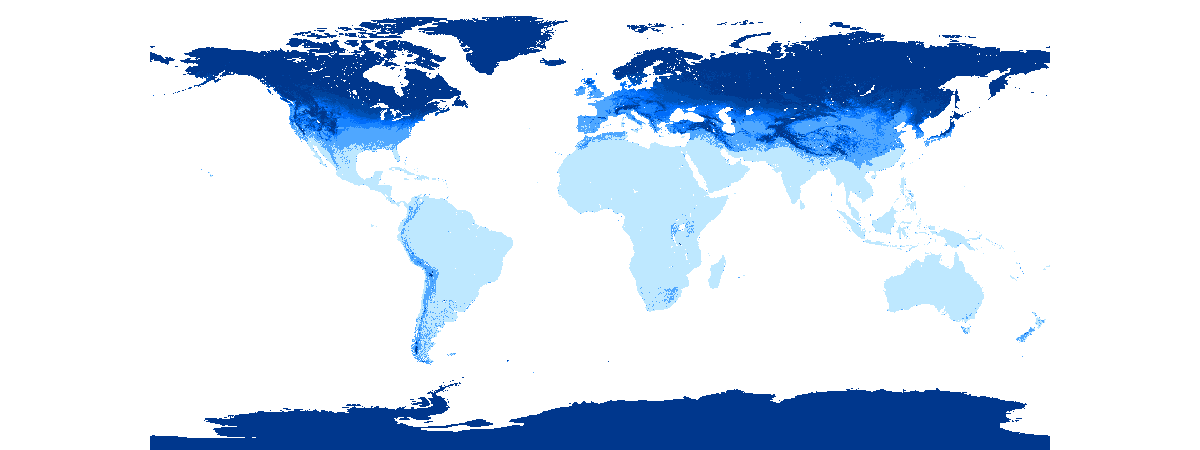

In [22]:
from arcgis.raster.functions import remap, multidimensional_filter, colormap
quarter1 = multidimensional_filter(quarter_mean_raster, variables='snow_cover_monthly_cmg', 
                                  dimension_definition="BY_VALUES",
                                  dimension_ranges=[{'dimension':'stdTime', 'Value':'1.0'}]
                                 )
mean_quarter1_remap = remap(quarter1, input_ranges=[-100,0.0001, 0.0001, 10, 10, 25, 25, 40, 40, 50, 50, 70, 70,95, 95, 101], output_values=[1,2,3,4,5,6,7,8])
mean_quarter1_colormap = colormap(mean_quarter1_remap, colormap=[[1,190,232,255], [2,79,167,255], [3,25,132,255], [4,0,108,249], [5,0,96,218], [6,0,82,184], [7,0,68,159], [8,0,55,141]])
mean_quarter1_colormap

### Analyze snow cover trend 

In [9]:
#calculate yearly mean snow cover frequency
from arcgis.raster.analytics import aggregate_multidimensional_raster
snow_cover_yearly = aggregate_multidimensional_raster(snow_cover_monthly, dimension='StdTime', variables=["snow_cover_monthly_cmg"],
                                                     aggregation_method='MEAN',
                                                     aggregation_definition='INTERVAL_KEYWORD',
                                                     interval_keyword='YEARLY',
                                                     output_name='snowcover_yearly_mean1',
                                                     gis=gis,
                                                     folder="demoSnowCover")

In [10]:
#generate trend raster
from arcgis.raster.analytics import generate_trend_raster
snowcover_yearly_trend = generate_trend_raster(snow_cover_yearly, variables = ["snow_cover_monthly_cmg"], dimension="StdTime", 
                                        trend_line_type='LINEAR', 
                                        output_name="snowcover_YearlyTrend1",
                                        gis=gis,
                                        folder="demoSnowCover")

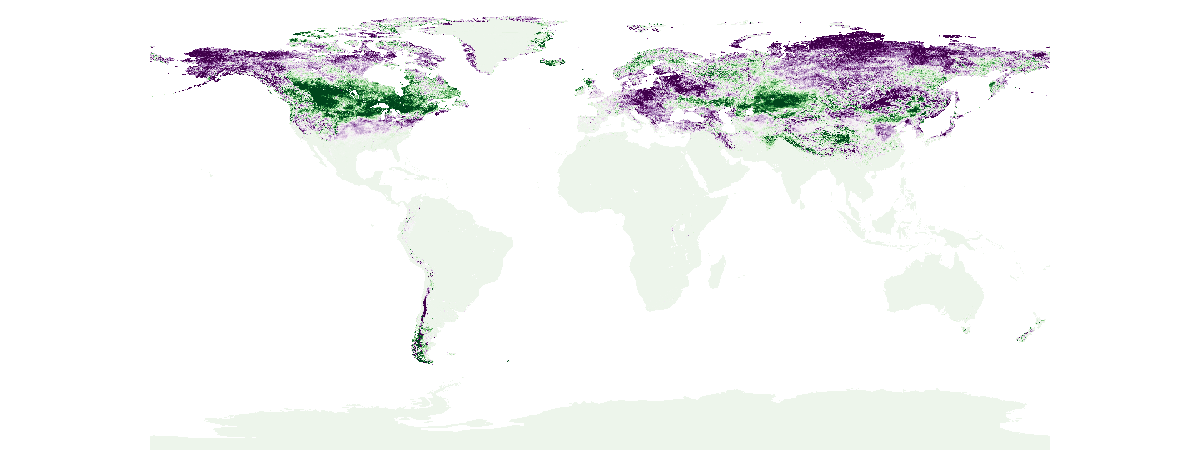

In [31]:
yearly_trend = Raster(snowcover_yearly_trend.layers[0].url, True, gis=gis)
yearly_trend_slope = extract_band(yearly_trend, band_ids = [1])
yearly_trend_slope_stretch = stretch(yearly_trend_slope ,stretch_type = "StdDev", dra=True) 
yearly_trend_slope_color = colormap(yearly_trend_slope_stretch, colormap_name="Purple-Green (Continuous)")
yearly_trend_slope_color

### Predict future snow cover frequency

In [13]:
from arcgis.raster.analytics import predict_using_trend_raster

prediction = predict_using_trend_raster(snow_cover_yearly_trend, variables='snow_cover_monthly_cmg', 
                                     dimension_definition="BY_VALUE",
                                     dimension_values=['2025-01-01T00:00:00','2025-01-31T00:00:00'],
                                     gis=gis,
                                     output_name="prediction2025_1",
                                     folder='demoSnowCover')

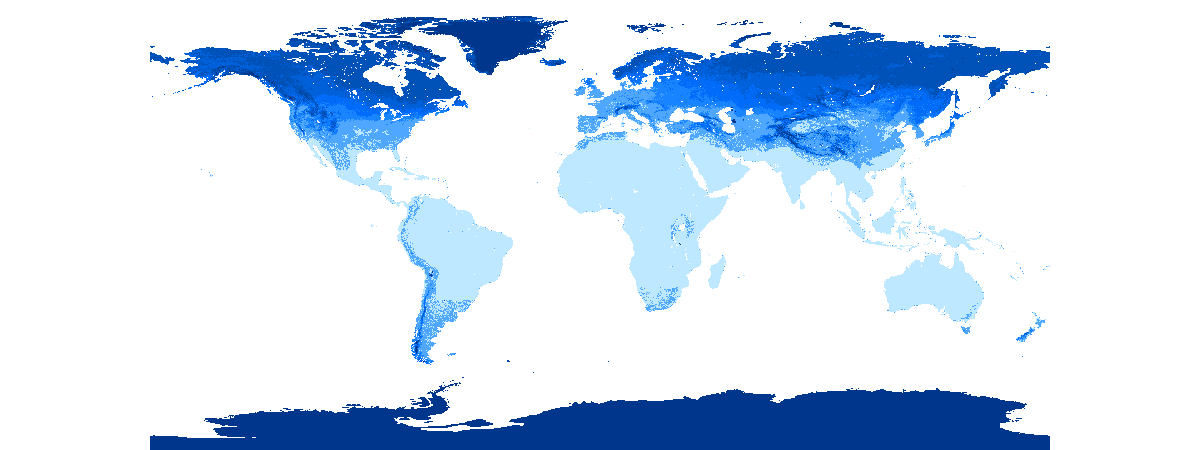

In [14]:
prediction_raster = Raster(prediction.layers[0].url, True, gis=gis)
predictiond_remap = remap(prediction_raster, input_ranges=[-100,0.0001, 0.0001, 10, 10, 25, 25, 40, 40, 50, 50, 70, 70,95, 95, 101], output_values=[1,2,3,4,5,6,7,8])
prediction_colormap = colormap(predictiond_remap, colormap=[[1,190,232,255], [2,79,167,255], [3,25,132,255], [4,0,108,249], [5,0,96,218], [6,0,82,184], [7,0,68,159], [8,0,55,141]])
prediction_colormap